# Introduction

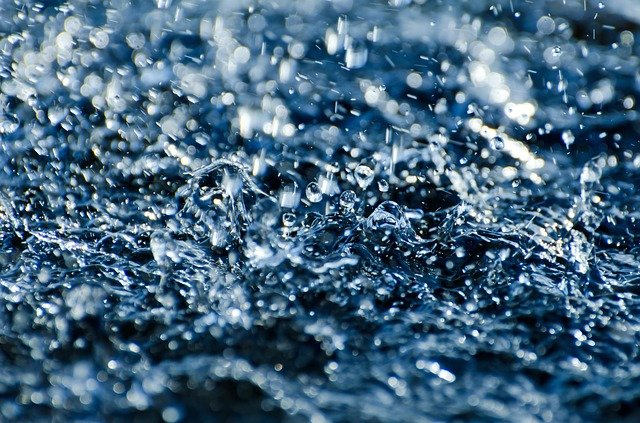

Rainfall has a significant impact on society. Festivals, all sorts of activities, and sports matches are examples of events that could be heavily influenced by rainfall. Therefore, this topic is studied heavily. The goal of this analysis is to predict if it is going to rain the next day, based on the weather measures of the day before. This creates a binary classification problem (1 = Rain and 0 = No Rain). The dataset consists of weather data in Australia over 10 years (1 Nov 2007 to 25 Jun 2017). 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

weather_aus = pd.read_csv("../input/weather-dataset-rattle-package/weatherAUS.csv")

weather_aus.head()

# Exploring 

In [ ]:
# Look at the statistics of the continous variables
weather_aus.describe()

**Comments**
* There is a wide range of minimum and maximum temperature. 
* The cloud variables have a high standard deviation compared to the mean. I will take a look a the distributions later and may standardize the variables. 
* The pressure variables have a low standard deviation. The distribution is close to their mean.

In [ ]:
# Check datatypes
weather_aus.dtypes

**Comments**
* The variables Date, Location, WindsGustDir, WindDir9am, WindDir3pm, RainToday, and RainTomorrow are categorical. I will later create dummy variables for these variables to meet the criteria of the machine learning algorithms. 
* I will transform the date variable to monthly's values, to prevent the low cardinality of the observations.

In [ ]:
plt.rcParams.update({'font.size': 5.5})
weather_aus.hist()
plt.show()

**Comments**
* Some of the variables are skewed (Rainfall, Evaporation, Pressure). I will standardize them. They need to be standardized because logistic regression is based on a linear relationship. Furthermore, the algorithms will perform better when they are scaled to a standard range. 
* I will use robust standardization. It ignores outliers and uses the median. This is the formula: value = (value – median) / (p75 – p25)

Let's look at the relationship between the weather measures on 3PM, the latest measure point, and Rainfall the next day. 

In [ ]:
plt.rcParams.update({'font.size': 10 })
plt.style.use('fivethirtyeight') 

In [ ]:
# Relation between 3pm measures and raining the next day
plt.subplots(figsize=(8, 5))
sns.boxplot(data=weather_aus, x="RainTomorrow", y = "WindSpeed3pm")

In [ ]:
plt.rcParams.update({'font.size': 10})
plt.style.use('fivethirtyeight') 

In [ ]:
plt.subplots(figsize=(8, 5))
sns.boxplot(data=weather_aus, x='RainTomorrow', y = "Temp3pm")

In [ ]:
plt.rcParams.update({'font.size': 10})
plt.style.use('fivethirtyeight')

In [ ]:
plt.subplots(figsize=(8, 5)) 
sns.boxplot(data=weather_aus, x='RainTomorrow', y = "Pressure3pm")

In [ ]:
plt.rcParams.update({'font.size': 10})
plt.style.use('fivethirtyeight')

In [ ]:
plt.subplots(figsize=(8, 5)) 
sns.boxplot(data=weather_aus, x='RainTomorrow', y = "Cloud3pm")

In [ ]:
plt.rcParams.update({'font.size': 10})
plt.style.use('fivethirtyeight')

In [ ]:
plt.subplots(figsize=(8, 5)) 
sns.boxplot(data=weather_aus, x='RainTomorrow', y = "Humidity3pm")

**Comments**
* The percentage of humidity at 3 PM, which is the amount of water vapor in the air, clearly is different between days where it rained the next days or did not.  
* The median percentage of clouds is quite higher when it has rained. However, there is a large distribution of clouds when it didn't rain. 
* Pressure and Temperature seem to be very close to each other with some overlap. 
* There are a lot of outliers.

In [ ]:
# Explore predictor variable
weather_aus['RainTomorrow'].value_counts()

In [ ]:
# Plot distribution of predictor variable
plt.style.use('fivethirtyeight') 

count_plot_predictor = sns.countplot(x = "RainTomorrow", data = weather_aus)
count_plot_predictor.set_title("Did it rain the next day?")

**Comments**
* 110316 times it didn't rain the next day and 31877 times it did rain. 
* This predictor is imbalanced with a ratio of 1: 3,46. An imbalanced predictor could bias our predictive accuracy. I may balance our classes later, but first, see how the basic model performs.

# Transforming

In [ ]:
weather_aus.isna().sum()

**Comments**
* There are quite a lot of missing values. Especially in the sunshine, evaporation, and clouds variables. Dealing with missing values is kind of arbitrary, but I will remove them for now.

In [ ]:
# Remove missing values. 
weather_aus.dropna(inplace = True)

In [ ]:
# Check again missing values
weather_aus.isna().sum()

In [ ]:
weather_aus['RainTomorrow'].value_counts()

In [ ]:
# Distribution of yes no after dropping missing values
plt.subplots(figsize=(8, 5))
plt.style.use('fivethirtyeight') 
count_plot_predictor = sns.countplot(x = "RainTomorrow", data = weather_aus)
count_plot_predictor.set_title("Did it rain the next day? (after removing NA values)")

**Commments**
* Classes are still imbalanced
* 43993 observations of no rain and 12427 observations of rain are left to train and test the model on.

In [ ]:
# Add month variable
weather_aus['Date']= pd.to_datetime(weather_aus['Date'])
weather_aus['Month'] = pd.DatetimeIndex(weather_aus['Date']).month

In [ ]:
# Make month variable a category / object type in order to get dummy variables later
weather_aus = weather_aus.astype({"Month": object})

In [ ]:
# Remove date variable
weather_aus = weather_aus.drop(columns = "Date")

In [ ]:
# Standardize continous variables with Robust scaler 
# Value = (value – median) / (p75 – p25)
from sklearn.preprocessing import RobustScaler

# Retrieve numerical columns to standardize
numerical_cols = weather_aus.select_dtypes(include=np.number).columns.tolist()

# Transform numerical values with robust scaler 
transformer = RobustScaler()
weather_aus[numerical_cols] = transformer.fit_transform(weather_aus[numerical_cols])

In [ ]:
# Look at the distribution again
plt.rcParams.update({'font.size': 5.5})
weather_aus.hist()
plt.show()

**Comments**
* The distributions still look a bit skewed. However, this robust transformation should lower the model bias and increase the accuracy. 

In [ ]:
# Create dummy variables for raintoday and tomorrow
weather_aus['RainToday'] = weather_aus['RainToday'].replace({'No':0, 'Yes':1})
weather_aus['RainTomorrow'] = weather_aus['RainTomorrow'].replace({'No':0, 'Yes':1})

In [ ]:
# Create K-1 dummy variables of categorical variables with the first value as a reference
weather_aus = pd.get_dummies(weather_aus, drop_first=True)

In [ ]:
pd.set_option('display.max_columns', None)

weather_aus.head()

Now, let's train our model and see if we can predict rainfall based on the weather parameters of the day before.

# Fitting

In [ ]:
from sklearn.model_selection import train_test_split

# create feature variables(X)
X = weather_aus.drop(["RainTomorrow"], axis=1)

# create predictor
y = weather_aus['RainTomorrow']

# create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [ ]:
len(X_train)

In [ ]:
len(X_test)

**Comments**
* We have 45136 rows (80%) of training data and 11284 rows (20%) of test data

In [ ]:
# Import machine learning algorithmn and evaluation reports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Instantiate the classifier 
lr = LogisticRegression(solver="liblinear", random_state=0) # liblinear works better for larger datasets

# Fit to the training data
lr.fit(X_train, y_train)

# Predict the labels of the test set
y_pred_lr = lr.predict(X_test)

# Print classification report of test dataset
print(classification_report(y_test,y_pred_lr))

In [ ]:
# Import machine learning algorithmn
from sklearn.svm import SVC

# Instantiate the classifier
svc = SVC(random_state=0)

# Fit the model
svc.fit(X_train, y_train)

# Predict the labels on the test dataset
y_pred_svc = svc.predict(X_test)

# Print classification report of test dataset
print(classification_report(y_test,y_pred_svc))

In [ ]:
# Import machine learning algorithmn
from sklearn.ensemble import RandomForestClassifier

# Instantiatie the classifier
random_forest = RandomForestClassifier(random_state=0)

# Fit the model
random_forest.fit(X_train, y_train)

# Predict on test dataset
y_pred_random_forest = random_forest.predict(X_test)

# Print classification report on test dataset
print(classification_report(y_test,y_pred_random_forest))

# Evaluating
The three models are doing quite well with accuracy around 85 percent. However, the recall score stays behind. The recall represents the number of correct predictions that it will rain tomorrow (true positives) divided by the number of correct predictions that it will rain (true positives) + the number of times it predicted no rainfall but it did rain (false negative). The latter seems to be frustrating and should be kept low. I've remarked earlier on the class imbalance of the predictor variable. There are not so many rain days to train on. Therefore, I am going to perform a logistic regression again with balanced classes. Balanced classes will have higher weights to the minority class (rain) and lower weights to the majority class (no rain.) The focus will be on the recall.

In [ ]:
# Balanced logistic regression
lr_b = LogisticRegression(class_weight = "balanced", solver="liblinear", random_state=0)

# Fit to the training data
lr_b.fit(X_train, y_train)

# Predict the labels of the test set
y_pred_lr_b = lr_b.predict(X_test)

# Print classification report
print(classification_report(y_test,y_pred_lr_b))

In [ ]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams.update({'font.size': 10})

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lr_b, X_test, y_test)  

**Comments**
* The recall did improve, to 79 percent! It looks like that the model balancing has worked. 
* The accuracy lowered a bit to 80 percent, but that's isn't a big deal because my focus is on keeping the false negatives low which represents a higher recall.

In [ ]:
# logistic regression feature importance

# Get importance
importance = lr_b.coef_[0]

# Sort importances
sorted_index = np.argsort(importance)

# Create labels
labels = X.columns[sorted_index] 

# make dataframe of importances
importance_df = pd.DataFrame({"Feature importance": importance[sorted_index], "Feature name": labels})

importance_df = importance_df.sort_values(by=['Feature importance'], ascending=False)

pd.set_option('display.max_rows', None)
print(importance_df)

In [ ]:
from sklearn.metrics import roc_curve
plt.rcParams.update({'font.size': 10})

# Get probabilities
lr_b.predict_proba(X_test)[:,1]
y_pred_prob = lr_b.predict_proba(X_test)[:,1]

# Create ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.plot([0, 1], [0, 1], "k--")

plt.title("ROC Curve of (balanced) Logistic Regression")

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_pred_lr_b)
print(auc)

# Conclusion

* Humidity on 3 PM is the most important positive feature that the logistic regression model uses to make predictions. This was already clear in the explorative analysis, where the median of the two classes of rain and not rain were widely separated. 
* Clouds on 3PM and Wind gust speed are strong positive predictors of Rainfall next day.
* The pressure on 3 PM is a strong negative predictor of rainfall the next day. That sounds reasonable because when the pressure is low, the air rises in the atmosphere where they meet. As the air rises, the water vapor within it condenses, forming clouds and often precipitation (Center for science education, 2021)
* Sunshine is a strong negative predictor of rainfall the next day. Again, sounds logical because when there is a lot of sunshine there are fewer clouds. 
* Something that isn't explaining if it will rain tomorrow is the maximum temperature, wind direction, and Rainfall. Rainfall is the amount of rainfall recorded for the day in mm.
* The area under the curve of the logistic regression is 0.79787

# References
1. https://scied.ucar.edu/learning-zone/how-weather-works/highs-and-lows-air-pressure